In [1]:
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import seaborn as sns
import functions
import seaborn as sns
from my_catboost import GradientBoosting
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# pd.options.display.float_format = '{:,.3f}'.format  # Переустанавливаем формат
pd.options.display.float_format = '{:,.0f}'.format

In [3]:
jobs_df = pd.read_csv("jobs_df.csv")
jobs_df.head(3)

,premium,name,department,has_test,response_letter_required,area,address,employer,snippet,schedule,working_time_intervals,accept_temporary,professional_roles,experience,employment,key_skills,average_salary,min_salary,max_salary,hours_since_publication
0,False,Разработчик Python,NaN,False,False,Москва,NaN,Гриндата,"{'requirement': 'Python от 2х лет. FastAPI, Fl...",Полный день,NaN,False,"Программист, разработчик",От 1 года до 3 лет,Полная занятость,[],NaN,NaN,NaN,27
1,False,AI/ML Engineer Стажёр,NaN,False,False,Ташкент,NaN,YATT YULDASHEV PULAT BAXTIYOROVICH,{'requirement': 'Идеальный кандидат уже имеет ...,Гибкий график,Можно сменами по 4-6 часов в день,False,"Программист, разработчик",Нет опыта,Стажировка,"['Python', 'PostgreSQL', 'ORM', 'Git', 'ООП', ...",NaN,NaN,NaN,77
2,False,Python-разработчик,NaN,False,False,Москва,"{'city': 'Москва', 'street': 'Пресненская набе...",ВТБ Капитал,"{'requirement': 'Python (flask/django, multipr...",Полный день,NaN,False,"Программист, разработчик",Нет опыта,Полная занятость,"['Python', 'SQL', 'Flask', 'Django Framework']",NaN,NaN,NaN,122


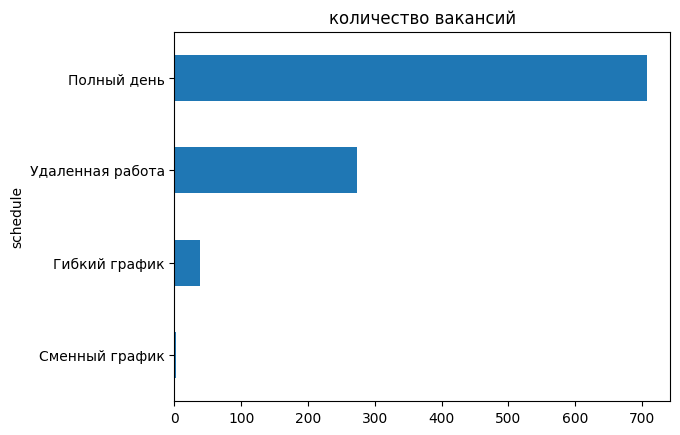

In [4]:
jobs_df['schedule'].value_counts().sort_values().plot.barh(title='количество вакансий')
plt.show()

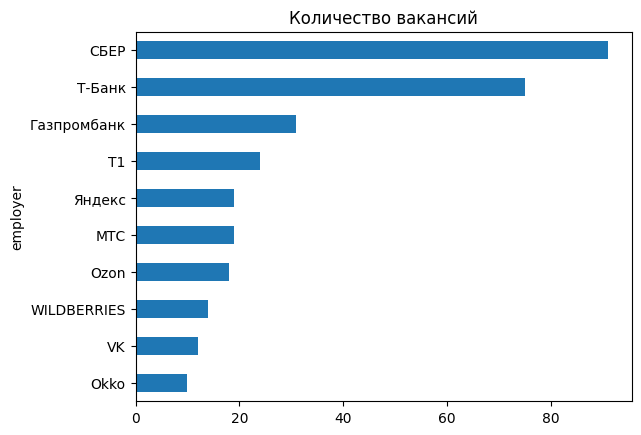

In [5]:
jobs_df.employer.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

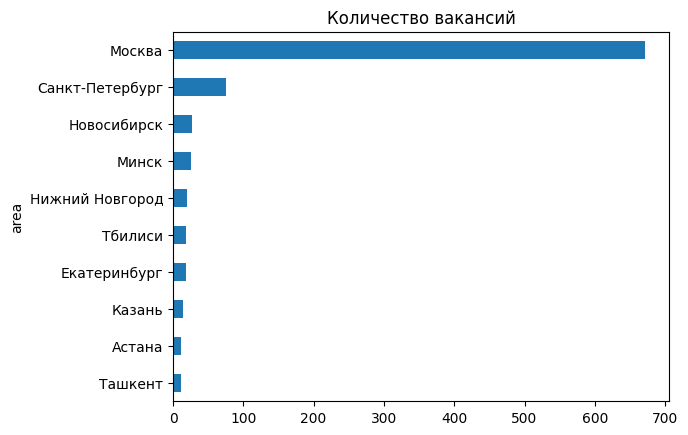

In [6]:
jobs_df.area.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

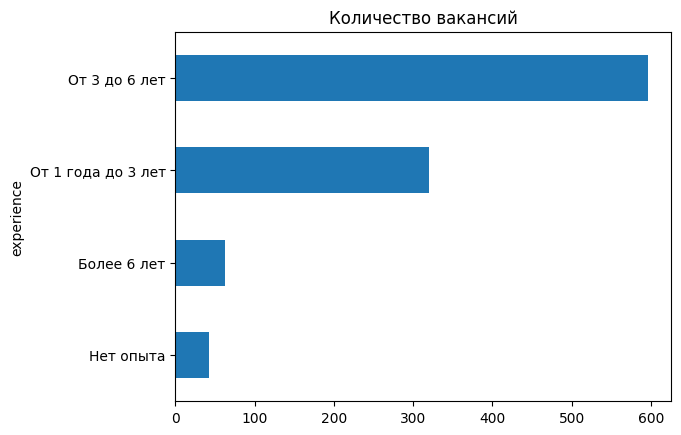

In [7]:
jobs_df.experience.value_counts().head(10).sort_values().plot.barh(title='Количество вакансий')
plt.show()

In [8]:
print('Количество вакансий с указанной зарплатой', (~jobs_df.average_salary.isna()).sum())
print('Доля вакансий с указанной зарплатой', format((~jobs_df.average_salary.isna()).mean(), '.2f'))

Количество вакансий с указанной зарплатой 148
Доля вакансий с указанной зарплатой 0.14


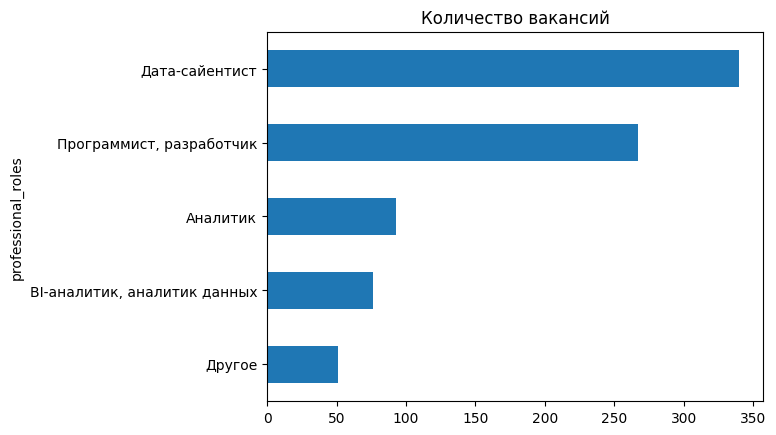

In [9]:
jobs_df.professional_roles.value_counts().head(5).sort_values().plot.barh(title='Количество вакансий')
plt.show()

In [10]:
functions.flatten_series(jobs_df.name.str.lower().str.split())\
.apply(lambda el: ''.join(char for char in el if char.isalnum()))\
.value_counts().head(20)

,count
data,412
engineer,296
scientist,261
ml,182
senior,133
в,122
,110
python,80
данных,78
middle,77


In [11]:
jobs_df['grade'] = jobs_df['name']\
.apply(lambda el: 'lead' if 'lead' in el.lower()
else 'middle_plus' if ('middle' in el.lower() and 'senior' in el.lower()) or 'middle+' in el.lower()
else 'senior' if 'senior' in el.lower()
else 'middle' if 'middle' in el.lower()
else 'junior' if 'junior' in el.lower()
else 'intern' if 'intern' in el.lower() or 'стажёр' in el.lower() or 'стажер' in el.lower()
else None)

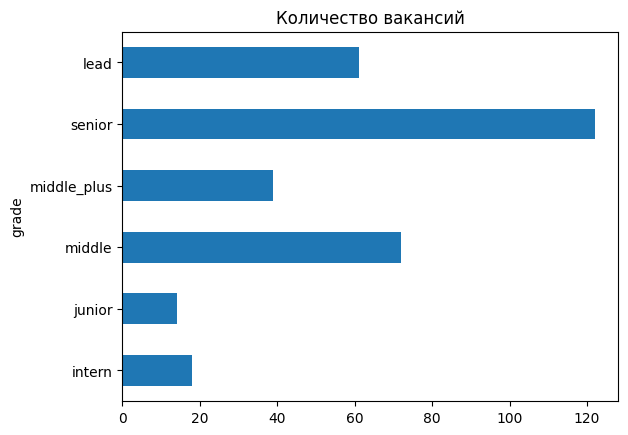

In [12]:
jobs_df.grade.value_counts()\
.loc[['intern',
      'junior',
      'middle',
      'middle_plus',
      'senior',
      'lead']].plot.barh(title='Количество вакансий')
plt.show()

In [13]:
jobs_df_f = jobs_df[~jobs_df['average_salary'].isna()]

In [14]:
X = jobs_df_f.drop(['average_salary', 'address', 'snippet', 'key_skills', 'min_salary',	'max_salary', 'hours_since_publication'], axis=1)
y = jobs_df_f['average_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost
import catboost as cb
from sklearn.model_selection import cross_val_predict

In [16]:
param_grid = {
    'iterations': [50, 100],
    'depth': [4, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [5, 7, 9, 11]
}

model = cb.CatBoostRegressor(cat_features=X.columns.tolist(), silent=True)

grid_search = GridSearchCV(model, param_grid, cv=4, scoring='neg_mean_absolute_error')
grid_search.fit(X_train.fillna('-'), y_train)

best_model = grid_search.best_estimator_
print('Лучшие параметры:', grid_search.best_params_)
print('MAE лучшей модели:', -grid_search.best_score_)


Лучшие параметры: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 11, 'learning_rate': 0.1}
MAE лучшей модели: 104069.1403475359


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [17]:
model = cb.CatBoostRegressor(cat_features=X.columns.tolist(), silent=True, iterations=100, depth=8)
y_pred = cross_val_predict(model, X_train.fillna('-'), y_train, cv=42)
model.fit(X_train.fillna('-'), y_train)
y_pred_test = model.predict(X_test.fillna('-'))

In [18]:
print('r2', r2_score(y_train, y_pred))
print('mape', mape(y_train, y_pred))

r2 0.39777703252563446
mape 1.2416629888440898


In [19]:
print('r2', r2_score(y_test, y_pred_test))
print('mape', mape(y_test, y_pred_test))

r2 -0.8756581398938277
mape 1.0617422204783062


In [20]:
model = cb.CatBoostRegressor(cat_features=X_train.columns.tolist(), silent=True, iterations=1000, depth=8)
model.fit(X_train.fillna('-'), y_train)

In [21]:
pd.DataFrame({'feature': model.feature_names_, 'importance': model.feature_importances_})\
.sort_values(by='importance', ascending=False)

,feature,importance
11,experience,35
7,schedule,16
13,grade,14
10,professional_roles,10
5,area,10
2,department,7
8,working_time_intervals,4
6,employer,2
9,accept_temporary,1
1,name,1


In [22]:
X_train.drop(['premium', 'name', 'has_test', 'response_letter_required', 'working_time_intervals', 'employer'], axis=1, inplace=True)
X_test.drop(['premium', 'name', 'has_test', 'response_letter_required', 'working_time_intervals', 'employer'], axis=1, inplace=True)

In [23]:
model = cb.CatBoostRegressor(cat_features=X_train.columns.tolist(), silent=True, depth = 4, iterations = 100, l2_leaf_reg = 11, learning_rate = 0.1)
y_pred = cross_val_predict(model, X_train.fillna('-'), y_train, cv=4)
print('r2', r2_score(y_train, y_pred))
print('mape', mape(y_train, y_pred))

r2 0.31435854281704323
mape 1.1413285309602863


In [24]:
model.fit(X_train.fillna('-'), y_train, plot=True)
y_pred_test = model.predict(X_test.fillna('-'))
print('r2', r2_score(y_test, y_pred_test))
print('mape', mape(y_test, y_pred_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

r2 -0.46429805635394117
mape 0.9203469706453189


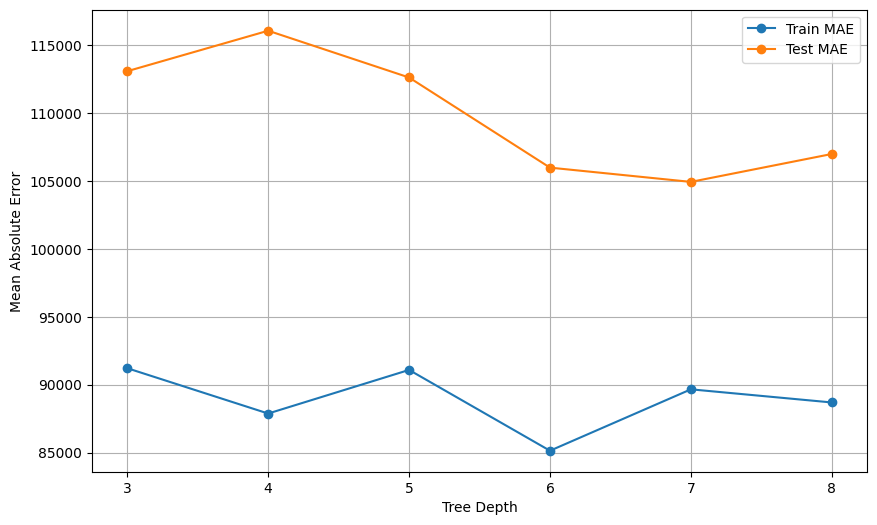

In [34]:
depths = [3, 4, 5, 6, 7, 8]
train_errors = []
test_errors = []

for depth in depths:
    model = cb.CatBoostRegressor(
        cat_features=X_train.columns.tolist(),
        silent=True,
        depth=depth,
        iterations=100,
        l2_leaf_reg=11,
        learning_rate=0.1
    )
    model.fit(X_train.fillna('-'), y_train)
    train_pred = model.predict(X_train.fillna('-'))
    train_errors.append(mae(y_train, train_pred))

    test_pred = model.predict(X_test.fillna('-'))
    test_errors.append(mae(y_test, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_errors, label='Train MAE', marker='o')
plt.plot(depths, test_errors, label='Test MAE', marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid()
plt.show()

In [26]:
model = cb.CatBoostRegressor(cat_features=X_train.columns.tolist(), silent=True)
model.fit(X_train.fillna('-'), y_train)

In [27]:
jobs_dummies = jobs_df[X_train.columns].fillna('-')
jobs_dummies_f = X_train.fillna('-')

In [28]:
jobs_df['predict_salary'] = model.predict(jobs_dummies[jobs_dummies_f.columns]).astype(int)

<function matplotlib.pyplot.show(close=None, block=None)>

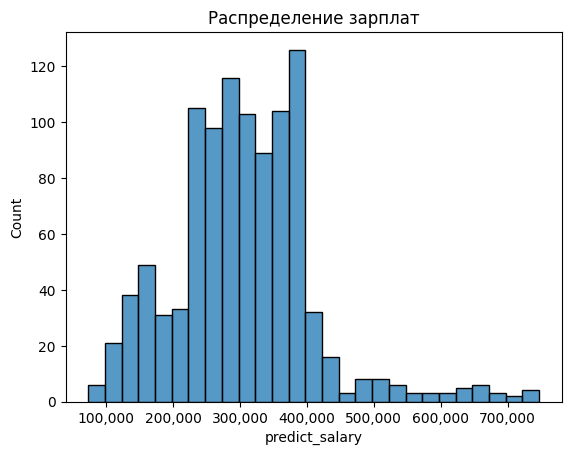

In [29]:
hist = sns.histplot(jobs_df['predict_salary'])
hist.set(title="Распределение зарплат")

import matplotlib.ticker as mtick
hist.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}')) # в начале зарплаты почему-то вывелись в формате 2.893174e+05, так что добавил такую обработку
plt.show

In [30]:
jobs_df['predict_salary'].describe()

,predict_salary
count,"1,021"
mean,"304,458"
std,"104,028"
min,"73,307"
25%,"239,295"
50%,"300,659"
75%,"365,960"
max,"746,909"


In [31]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Пример использования:
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies = pd.get_dummies(X_test)
X_test_aligned = functions.align_columns(X_train_dummies, X_test_dummies)

grid_search = GridSearchCV(GradientBoosting(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train_dummies, y_train)

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# best_model = GradientBoosting(n_estimators=300, learning_rate=0.01, max_depth=3)
y_pred = cross_val_predict(best_model, pd.get_dummies(X_train), y_train, cv=4)
print('r2', r2_score(y_train, y_pred))
print('mape', mape(y_train, y_pred))

y_pred_test = best_model.predict(pd.get_dummies(X_test_aligned))
print('r2', r2_score(y_test, y_pred_test))
print('mape', mape(y_test, y_pred_test))

Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
r2 0.41092055296107644
mape 0.9031061590326448
r2 -0.0771918264363407
mape 0.7463655157217207


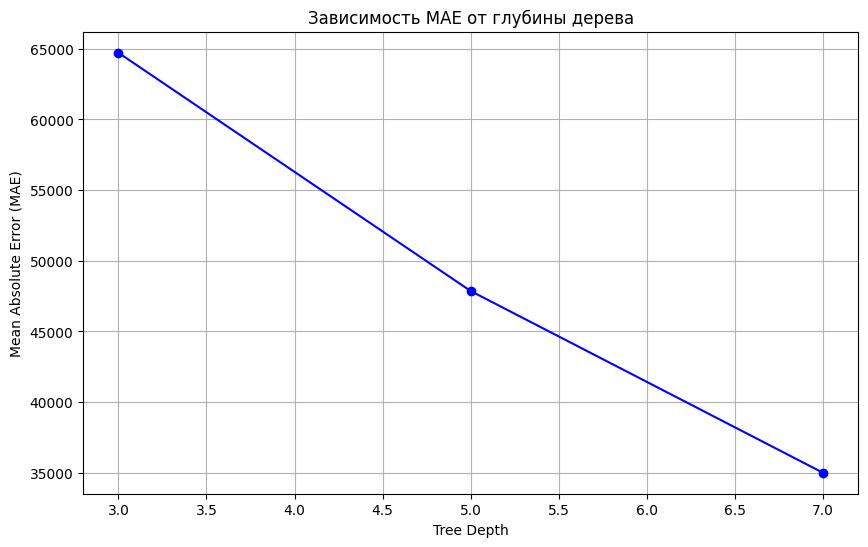

In [33]:
depths = [3, 5, 7]

errors_by_depth = functions.train_with_depth_variation(X_train_dummies, y_train, depths)

plt.figure(figsize=(10, 6))
plt.plot(list(errors_by_depth.keys()), list(errors_by_depth.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Tree Depth")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Зависимость MAE от глубины дерева")
plt.grid()
plt.show()

**Комментарии до правок:**

Мне выдавало ошибку из-за того, что cross_val_predict в scikit-learn ожидает, что объект модели будет наследовать интерфейс scikit-learn и реализовывать методы get_params и set_params, так что я добавил их в модель

Я написал упрощенную версию CatBoost и не расписывал деревья, лектор сказал норм

Параметры, которые были добавлены:
n_estimators — количество деревьев, learning_rate — скорость обучения .

**Комментарии после правок:**

Судя по графику функции потерь оригинальной модели Catboost глубина дерева не сильно влияет на mae. В модели my_catboost, которую я написал более четко видно, что при увеличении глубины дерева mae уменьшается.

Если говорить о метрике r2 модели, то на тренировочных данных она показывала довольно слабый результат, а на тестовых плохой. Думаю это из-за недостаточно большого датасета, к тому же, зарплата была указана лишь в 15% вакансий